In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

from tqdm.notebook import tqdm

from joblib import delayed, Parallel

import matplotlib.pyplot as plt
import itertools

# Árvores de Decisão

Nesta aula vamos estudar um método de classificação chamado de Árvore de Decisão. A "árvore" é apenas uma abstração de uma estrutura de **regras de decisão** na forma 

``SE atributo (<)= valor ENTÃO avalie a regra x, SENÃO avalie a regra y`` 

Onde as regras x e y podem ser outras regras de decisão ou **folhas**, que marcam o término da estrutura e representam a estimativa da predição.

Cada regra de decisão baseia-se apenas em um único atributo, assim como os classificadores baseados em limiares, que vimos no início deste curso. Desta forma, a árvore de decisão pode ser interpretada como uma função por partes, onde cada parte representa um classificador por limiar.

Existem muitos algoritmos para a construção de árvores de decisão. Nesta aula vamos focar em alguns pontos importantes relacionados ao **uso** das árvores de decisão. O canal StatQuest no YouTube tem um vídeo muito didático que explica a indução (construção) de árvores de decisão baseada em um algoritmo guloso:

[StatQuest - Decision and Classification Trees, Clearly Explained!!!](https://www.youtube.com/watch?v=_L39rN6gz7Y)


As árvores de decisão se destacam por serem **modelos caixa-branca**, ou seja, é possível interpretá-las e obter explicações sobre como a classificação foi realizada. Além disto, não é necessário normalizar os dados.

Nesta aula vamos usar a base de dados *iris*. Cada instância representa uma flor e os atributos são medidas do comprimento e largura das sépalas e pétalas da flor. O objetivo é determinar a espécie da flor com base nas medidas. Há 3 espécies na base de dados: *setosa*, *virginica* e *versicolor*.



In [2]:
ds = load_iris(as_frame=True)

In [3]:
X = ds.data
y = ds.target
for i, n in enumerate(ds.target_names):
    y.replace(i, n, inplace=True)

Inicialmente vamos explorar alguns parâmetros do algoritmo de indução da árvore de decisão. Para ficar mais fácil de ver o que cada parâmetro faz, vamos usar apenas um particionamento dos dados. Na Seção [Otimizando Parâmetros](#otimizando_parametros) mostro um procedimento para escolher a melhor combinação de hiperparâmetros, bem como fazer avaliação estatística dos modelos usando validação cruzada.

In [4]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

A biblioteca *sklearn* possui uma implementação de árvore de decisão implementada na classe ``DecisionTreeClassifier`` que fica no módulo ``sklearn.tree``. Atualmente esta implementação não trata atributos categóricos. Neste caso é necessário realizar *one-hot encoding* para codificar as variáveis categóricas.

In [5]:
#Instancia uma árvore de decisão
ad = DecisionTreeClassifier()

#Realiza a criação da árvore de acordo com os dados de treino.
#A criação da árvore é chamada de indução
ad.fit(X_treino, y_treino)

DecisionTreeClassifier()

A função ``plot_tree`` do módulo ``sklearn.tree`` mostra uma representação gráfica de uma árvore de decisão.

<a id='arv1'></a>

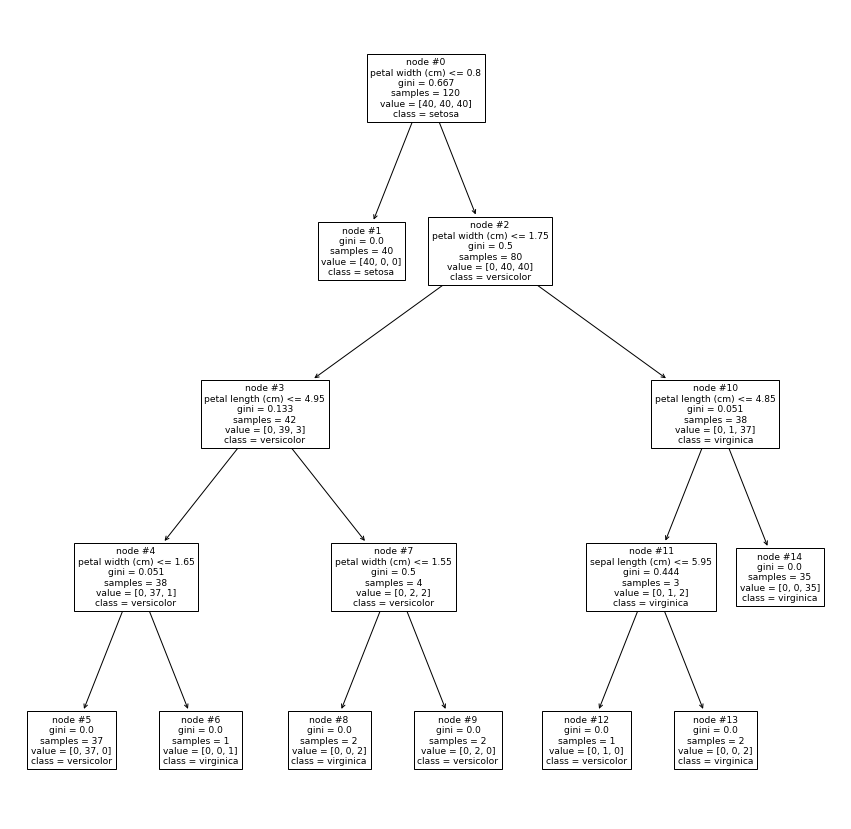

In [6]:
plt.figure(figsize=(15,15))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.show()

In [7]:
pred = ad.predict(X_teste)
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



O resultado da árvore de decisão com valores-padrão para os hiperparâmetros foi de 97% de f1-score (*weighted*, ponderado) no conjunto de teste avaliado. Este é um bom resultado para esta base de dados. Entretanto, esta base de dados é considerada muito fácil pois ela possui separabilidade praticamente linear, conforme vimos no início do curso. 

Em problemas mais difíceis as árvores de decisão sofrem com o problema de ***overfitting*** (sobreajuste). *Overfitting* é quando o modelo fica muito ajustado ao conjunto de treinamento, prejudicando sua capacidade de generalização. Este problema é muito comum com árvores de decisão pois, tradicionalmente, elas são construídas de forma que são geradas quantas regras forem necessárias para que todos os exemplos do conjunto de treinamento sejam contemplados.

## Limitando o número mínimo de exemplos para expandir um nó

Note que na árvore [acima (link)](#arv1) que o nó \#7 foi criado para classificar apenas 4 exemplos do conjunto de treinamento, e o nó \#11 foi criado para classificar apenas 3 exemplos do conjunto de treinamento. É possível que a criação de nós que separam tão poucos exemplos não contribuam para a generalização. Assim como fizemos na SVM, aceitar "errar" algumas instâncias no conjunto de treinamento para melhorar a chance de acertar no conjunto de testes é uma forma de melhorar a generalização. Uma forma de impedir que estes nós sejam expandidos é impor a condição que a expansão de um nó só seja realizada somente quando houver uma quantidade mínima de instâncias do conjunto de treinamento "pendurados" naquele nó.

O parâmetro ``min_samples_split`` do construtor da árvore de decisão indica a quantidade mínima de exemplos do conjunto de treinamento no nó para que ele seja expandido em uma nova regra de decisão.

In [8]:
ad = DecisionTreeClassifier(min_samples_split=10)
ad.fit(X_treino, y_treino)

DecisionTreeClassifier(min_samples_split=10)

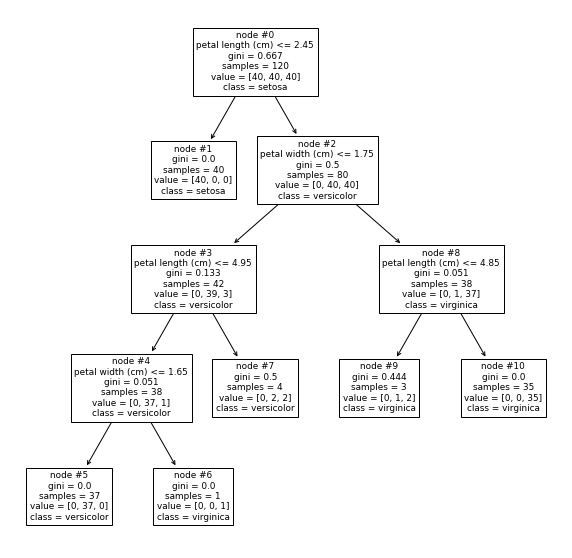

In [9]:
plt.figure(figsize=(10,10))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.show()

Compare esta árvore com a árvore [anterior](#arv1). Note como esta árvore possui menos regras de decisão que a árvore anterior. Dizemos que esta restrição restringe a flexibilidade da árvore, aumentando o **viés** do modelo (classificador). Este viés, desde que não seja muito alto, diminui a **variância** do classificador, diminuindo, por consequência, o sobreajuste.

A restrição da flexibilidade da árvore que implica em uma árvore com menos nós é conhecida como **poda**.

In [10]:
pred = ad.predict(X_teste)
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



A árvore menor resultou em f1-score de 93% no mesmo conjunto de testes usado para avaliar a árvore anterior. Esperávamos obter um resultado melhor como consequência da restrição imposta na segunda árvore. Entretanto, devemos manter em mente que esta base de dados já é fácil. Além disto, para comparar os dois métodos o ideal é usar validação cruzada, conforme já exploramos anteriormente.

## Limitando o número de exemplos nas folhas

Outra estratégia de poda comumente utilizada é restringir o número de exemplos nas folhas. 

O parâmetro ``min_samples_leaf`` do construtor da árvore de decisão indica a quantidade mínima de exemplos do conjunto de treinamento em um nó para que ele seja considerado uma folha.

In [11]:
ad = DecisionTreeClassifier(min_samples_leaf=10)
ad.fit(X_treino, y_treino)

DecisionTreeClassifier(min_samples_leaf=10)

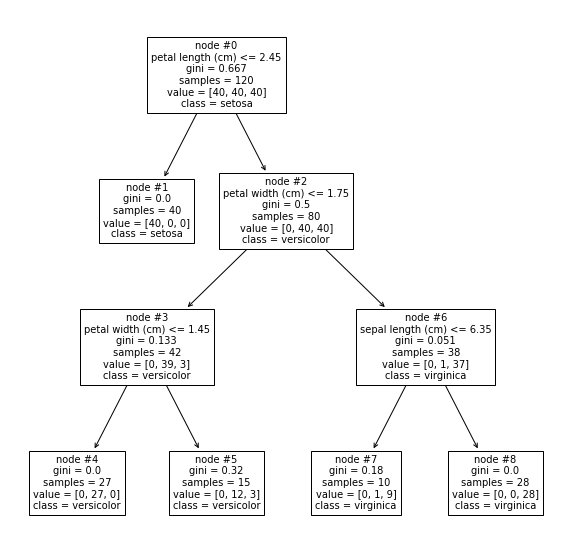

In [12]:
plt.figure(figsize=(10,10))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.show()

Note como nenhuma folha (nós \#1, \#4, \#5, \#7 e \#8) possui menos que 10 exemplos (samples).

In [13]:
pred = ad.predict(X_teste)
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



Note que o f1-score também foi de 93%.

## Limitando a profundidade máxima da árvore

Uma estratégia ainda mais "agressiva" que pode ser usada para diminuir a flexibilidade da árvore é limitar a profundidade máxima da árvore. A construção da árvore é simplesmente interrompida se atingir a profundidade máxima.

O parâmetro ``max_depth`` do construtor da árvore de decisão indica a profundidade máxima da árvore.


In [14]:
ad = DecisionTreeClassifier(max_depth=2)
ad.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=2)

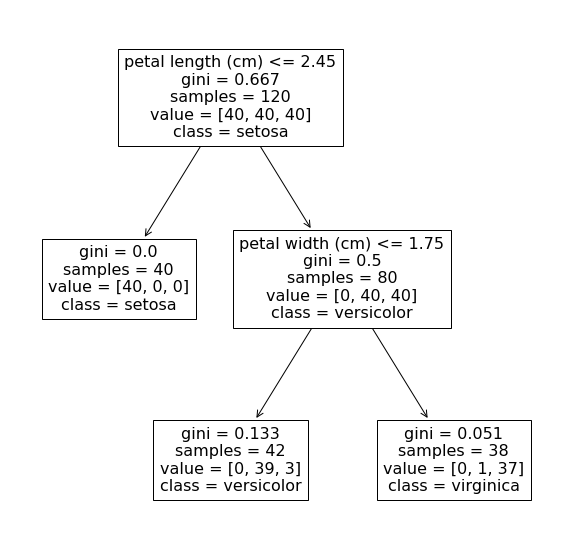

In [15]:
plt.figure(figsize=(10,10))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns)
plt.show()

Note que a profundidade da árvore é 2, conforme especificado pelo parâmetro ``max_depth``. A profundidade máxima é a distância percorrida da raíz da árvore até a folha mais profunda.

In [16]:
pred = ad.predict(X_teste)
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



Note que, mesmo com apenas 2 regras de decisão obtivemos o resultado de 93%, que é o mesmo que obtivemos com as demais operações de poda apresentadas. Novamente, destaco que para mostrar que o resultado não é diferente seria necessário usar validação cruzada e realizar o teste de hipótese nula.

<a id='otimizando_parametros'></a>

## Otimizando os parâmetros

Os exemplos acima servem apenas para visualizar o efeito dos parâmetros. Para escolher o modelo ideal (qual configuração de poda generaliza melhor) usamos validação cruzada para avaliar o efeito dos parâmetros em vários particionamentos diferentes, assim como fizemos na última aula para escolher entre usar a SVM e o KNN.

A função ``selecionar_melhor_ad`` faz a escolha da melhor combinação de hiperparâmetros no conjunto de validação. Em relação às funções semelhantes implementadas anteriormente (``selecionar_melhor_k_knn`` e ``selecionar_melhor_svm``), a principal diferença é a opção de validação cruzada para a escolha dos hiperparâmetros. O parâmetro ``cv_folds`` controla o número de folds usados (ou recebe um "*splitter*" como ``StratifiedKFold``) na validação cruzada para a seleção de hiperparâmetros.

In [17]:
def selecionar_melhor_ad(X_treino, X_val, y_treino, y_val, n_jobs=4, cv_folds=None,
                         max_depths=[None], min_samples_leafs=[1], min_samples_splits=[2]):
    
    def treinar_ad(max_depth, min_samples_leaf, min_samples_split, X_treino, X_val, y_treino, y_val):
        ad = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=1)
        ad.fit(X_treino, y_treino)
        pred = ad.predict(X_val)
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
        #Se for pra usar validação cruzada, usar GridSearchCV
        ad = DecisionTreeClassifier()
        
        #Configurar os valores que serão testados para cada parâmetro
        pg = {
            'max_depth' : max_depths,
            'min_samples_leaf' : min_samples_leafs, 
            'min_samples_split' : min_samples_splits,
        }
        
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        ad = GridSearchCV(ad, pg, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        ad.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = (ad.best_params_['max_depth'], ad.best_params_['min_samples_leaf'], ad.best_params_['min_samples_split'])
        melhor_val = ad.best_score_
        
    else:
        combinacoes_parametros = list(itertools.product(max_depths, min_samples_leafs, min_samples_splits))
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_ad)
                                         (md, msl, mss, X_treino, X_val, y_treino, y_val) for md, msl, mss in combinacoes_parametros)

        melhor_val = max(f1s_val)
        melhor_comb = combinacoes_parametros[np.argmax(f1s_val)]
        melhor_md, melhor_msl, melhor_mss = melhor_comb

        ad = DecisionTreeClassifier(max_depth=melhor_md, min_samples_leaf=melhor_msl, min_samples_split=melhor_mss, random_state=1)
        ad.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return ad, melhor_comb, melhor_val

A função ``do_cv_ad`` faz a avaliação da árvore de decisão por validação cruzada (descrita por ``cv_splits``). Para cada partição a melhor combinação de hiperparâmetros é encontrada (com um único conjunto de validação ou por validação cruzada, dependendo do parâmetro ``param_cv_folds``). O dicionário ``params_kwargs`` contém listas de parâmetros que devem ser avaliados para encontrar a melhor combinação. As chaves estão listadas abaixo, e os valores são listas com os parâmetros:

* ``max_depths``
* ``min_samples_leafs``
* ``min_samples_splits``

In [18]:
def do_cv_ad(X, y, cv_splits, param_cv_folds=None, **params_kwargs):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ad, melhor_comb, _ = selecionar_melhor_ad(X_treino, X_val, y_treino, y_val, cv_folds=param_cv_folds, **params_kwargs)
        pred = ad.predict(X_teste)

        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)
        
        pgb.update(1)
        
    pgb.close()
    
    return f1s

In [19]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

## Testes

### Avaliação da árvore de decisão com os parâmetros-padrão (DEF)

In [20]:
ad_f1s_default = do_cv_ad(X.values, y, 10)
imprimir_estatisticas(ad_f1s_default)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.94 +- 0.07, min: 0.80, max: 1.00


### Avaliação da árvore de decisão otimizando apenas a profundidade máxima (MD)

Neste teste estamos usando validação cruzada com 10 folds para a otimização dos hiperparâmetros.

In [21]:
ad_f1s_md = do_cv_ad(X.values, y, 10, param_cv_folds=10, **{'max_depths' : [None,2, 3, 4, 5]})
imprimir_estatisticas(ad_f1s_md)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.93 +- 0.06, min: 0.80, max: 1.00


### Avaliação da árvore de decisão otimizando apenas a quantidade mínima de exemplos nas folhas (MSL)

Neste teste estamos usando validação cruzada com 10 folds para a otimização dos hiperparâmetros.

In [22]:
ad_f1s_msl = do_cv_ad(X.values, y, 10, param_cv_folds=10, **{'min_samples_leafs' : [3, 5, 10, 15, 20, 30]})
imprimir_estatisticas(ad_f1s_msl)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.96 +- 0.05, min: 0.86, max: 1.00


### Avaliação da árvore de decisão otimizando apenas a quantidade mínima de exemplos para expandir um nó (MSS)

Neste teste estamos usando validação cruzada com 10 folds para a otimização dos hiperparâmetros.

In [23]:
ad_f1s_mss = do_cv_ad(X.values, y, 10, param_cv_folds=10, **{'min_samples_splits' : [4, 8, 16, 32, 40]})
imprimir_estatisticas(ad_f1s_mss)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.94 +- 0.06, min: 0.80, max: 1.00


### Avaliação da árvore de decisão otimizando todos os hiperparâmetros de uma vez (TUDO)

Neste teste estamos usando validação cruzada com 10 folds para a otimização dos hiperparâmetros.

In [24]:
ad_f1s_tudo = do_cv_ad(X.values, y, 10, param_cv_folds=10, **{'min_samples_leafs' : [3, 5, 10, 15, 20, 30],
                                                             'min_samples_splits' : [2, 4, 8, 16, 32, 40],
                                                             'max_depths' : [None,2, 3, 4, 5]})
imprimir_estatisticas(ad_f1s_tudo)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.96 +- 0.05, min: 0.86, max: 1.00


### Análise Estatística

A tabela abaixo resumo os resultados obtidos nos testes acima:

| Experimento | *f1-score* médio |
| :-: | :-: |
| DEF | $0.94 \pm 0.07$ |
| MD | $0.93 \pm 0.06$ |
| MSL | $0.96 \pm 0.05$ |
| MSS | $0.94 \pm 0.06$ |
| TUDO | $0.96 \pm 0.05$ |

O melhor resultado obtido foi com MSL e TUDO ($0.96 \pm 0.05$). O pior resultado foi obtido com MD ($0.93 \pm 0.06$). Vamos verificar se a variação na média entre o melhor e o pior resultado é significativa usando o teste de hipótese nula. Se a variação entre o melhor resultado e o pior resultado não for significativa, a variação entre os outros pares de resultados provavelmente também não são significativas.

A função ``rejeitar_hip_nula`` recebe 2 conjuntos de resultados (no nosso caso listas de resultados por fold) e retorna se a hipótese nula deve ser rejeitada considerando o limiar de corte ``alpha``. A função também retorna o p-valor.

In [25]:
from scipy.stats import ttest_ind_from_stats
def rejeitar_hip_nula(amostra1, amostra2, alpha=0.05):
    media_amostral1, desvio_padrao_amostral1, _, _ = calcular_estatisticas(amostra1)
    media_amostral2, desvio_padrao_amostral2, _, _ = calcular_estatisticas(amostra2)
    
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, len(amostra1), media_amostral2, desvio_padrao_amostral2, len(amostra2))
    return (pvalor <= alpha, pvalor)

In [26]:
rejeitar_hip_nula(ad_f1s_tudo, ad_f1s_md)

(False, 0.1883775048583213)

Neste caso a hipótese nula não pode ser rejeitada com 95% de confiança (``alpha=0.05``). Desta forma, não é possível afirmar que há diferença significativa entre o melhor e o pior resultado obtido.